In [1]:
from env import *

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
build_cdp = lambda learner, m: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)

## Curve extrapolation

### Utility functions

In [4]:
@np.vectorize
def pretty_round(x):
    increments = [
        (10,1),
        (100,10),
        (250,50),
        (1000,100),
        (2500,500),
        (10000,1000),
        (50000,5000),
        (None,10000),
    ]
    assert increments[-1][0] is None
    for ub, r in increments:
        if ub is None or x<=ub:
            return round(x/r)*r

def sample(cdp, n0=None, samples_per_n=1, n_min=None, random_state=None):
    rng = np.random.default_rng(random_state)
    x = []
    y = []
    for i, c in enumerate(cdp.cost):
        if c==0:
            continue
        if n_min is not None and c<n_min:
            continue
        for k in range(samples_per_n):
            if n0 is not None and sum(x)+c > n0:
                return x,y
            acc = rng.choice(cdp.acc_p[i])
            x.append(c)
            y.append(acc)
    return x,y
        
class EstimatedContract:
    def __init__(self,true_cdp,pow3,metadata=None):
        self.true_cdp = true_cdp
        self.pow3 = pow3
        self.metadata = metadata
        self.est_cdp = dclf.BootstrappedBinomialMixtureContractDesignProblem(
            acc_p=list(pow3(cdp.cost[1:])),
            cost=list(cdp.cost[1:]),
            m=true_cdp.m,
            ensure_zero_cost_action=True,
        )
        assert self.est_cdp.m == self.true_cdp.m
    
    @classmethod
    def from_sample(cls, true_cdp, n0, samples_per_n=1, random_state=None, weight_func=lambda x:np.ones(len(x)), bounds=(0,[1,5,5])):
        x,y = sample(cdp, samples_per_n=samples_per_n, n0=n0, random_state=random_state)
        for attempt in range(10):
            try:
                pow3 = dclf.Pow3.from_data(x,y,sigma=weight_func(np.array(x)), bounds=bounds)
                break
            except RuntimeError as e:
                pow3 = None
        assert pow3 is not None
        return cls(true_cdp,pow3,metadata=locals())
    
def get_response(b, true_cdp, est_cdp):
    threshold_contract = dclf.FixedBudgetThresholdContract.design(est_cdp,b)
    response = dclf.get_agent_response(true_cdp,threshold_contract['t'])
    return response
    
@np.vectorize
def attained_acc(b, true_cdp, est_cdp):
    response = get_response(b, true_cdp, est_cdp)
    return cdp.mean_acc[response.selected_action]

### Constants

In [5]:
selected_learners = np.array([
    'sklearn.neural_network.MLPClassifier',
    'sklearn.ensemble.GradientBoostingClassifier',
])

selected_openmlid = dclf.mnist_openmlid


In [6]:
selected_learner = selected_learners[0]
print(f'Selected classifier: {selected_learner}')

selected_m = 100
selected_n0 = 200

build_cdp = lambda learner, m: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series, m=m)
)


Selected classifier: sklearn.neural_network.MLPClassifier


### Compute

In [7]:

n0_vec = np.geomspace(5e1,1e3,10)
print('n0_vec:',n0_vec)
rng = np.random.default_rng(1234)

n_samples_vec = param([1,3,5],'r_values')
weights = {
    'uniform': lambda x: x*0+1,
    'inv': lambda x: 1/x,
    'inv_sqrt': lambda x: 1/np.sqrt(x),
}
bounds = {
    'conservative': (0,[1,5,5]),
}

n_reps = 100

est_results = []

cdp = build_cdp(selected_learner, selected_m)
for rep in tqdm(range(n_reps)):
    # for w_name, w_f in weights.items():
    for b_name, bound in bounds.items():
        for n_samples in n_samples_vec:
            for n0 in n0_vec:
                try:
                    ec = EstimatedContract.from_sample(
                        true_cdp=cdp,
                        n0=n0,
                        samples_per_n=n_samples,
                        random_state=rng,
                        bounds=bound,
                    )
                except RuntimeError:
                    print(f'Failed to converge at n0={n0}, rep={rep}. Skipping')
                    continue
                est_results.append({
                    'n0': n0,
                    'samples_per_n': n_samples,
                    'bound_type': b_name,
                    # 'weights': w_name,
                    'rep': rep,
                    'estimated_contract': ec,
                })

est_results_df = pd.DataFrame(est_results)


n0_vec: [  50.           69.7475397    97.29438588  135.72088083  189.32395047
  264.09759503  368.40314986  513.9042664   716.87116444 1000.        ]


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/edens/opt/anaconda3/envs/dclf/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Figure saved as ./output/extrapolated_contract_analysis.pdf


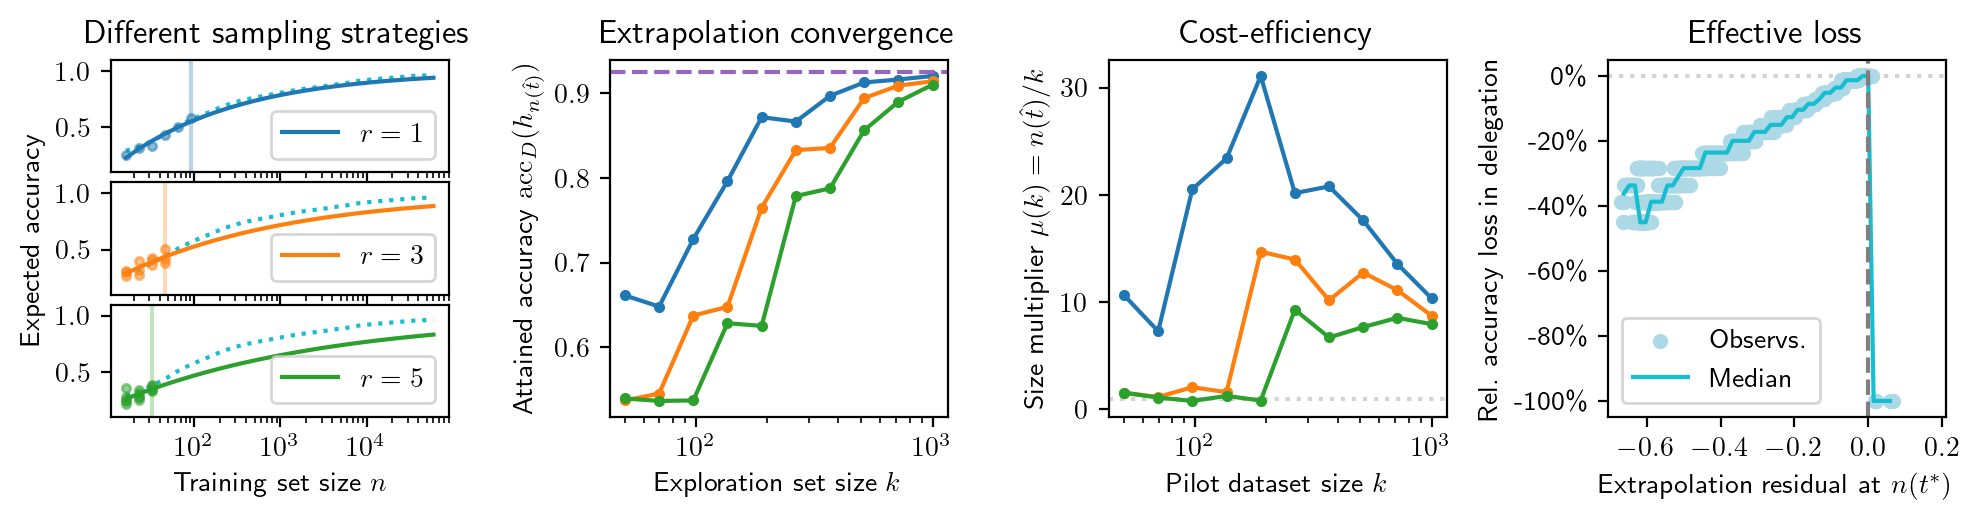

In [8]:
fig = plt.figure(figsize=(10,2.7), tight_layout={'w_pad':1,'h_pad':0})
gs = matplotlib.gridspec.GridSpec(3, 4)
axs = np.array([
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[:, 1]),
    fig.add_subplot(gs[:, 2]),
    fig.add_subplot(gs[:, 3]),
])
axs_it = iter(axs.ravel())

selected_b = 3e4 # MLP

#
# Sampling strategies
#

est_results_analyzed_df = (
    est_results_df
    .assign(
        max_acc_in_trainset=lambda df: df['estimated_contract'].map(lambda ec: max(ec.metadata['y'])),
        attained_acc=lambda df: df['estimated_contract'].map(lambda ec: attained_acc(
            b=selected_b,
            true_cdp=ec.true_cdp,
            est_cdp=ec.est_cdp,
        )),
        response_to_true=lambda df: df['estimated_contract'].map(lambda ec: get_response(
            b=selected_b,
            true_cdp=ec.true_cdp,
            est_cdp=ec.true_cdp,
        )),
        response_to_est=lambda df: df['estimated_contract'].map(lambda ec: get_response(
            b=selected_b,
            true_cdp=ec.true_cdp,
            est_cdp=ec.est_cdp,
        )),
        attained_n=lambda df: df.apply(
            lambda row: row['estimated_contract'].true_cdp.cost[row['response_to_est'].selected_action],
            axis=1
        ),
        best_acc=lambda df: df['estimated_contract'].map(lambda ec: attained_acc(
            b=selected_b,
            true_cdp=ec.true_cdp,
            est_cdp=ec.true_cdp,
        )),
        acc_gain=lambda df: df['attained_acc']-df['max_acc_in_trainset'],
        est_acc=lambda df: df.apply(
            lambda row: row['estimated_contract'].pow3(row['estimated_contract'].true_cdp.cost[row['response_to_true'].selected_action]),
            axis=1,
        ),
        est_curve=lambda df: df['estimated_contract'].map(lambda ec: ec.pow3(ec.true_cdp.cost[1:])),
        d_est=lambda df: df['est_acc']-df['best_acc'],
        # d_acc=lambda df: 1-df['attained_acc']/df['best_acc'],
        d_acc=lambda df: df['attained_acc']/df['best_acc']-1,
    )
)

def plot_sampling_strategies(axs_it):
    for i,n_samples,ax in zip(itertools.count(), n_samples_vec,axs_it):
        row = (
            est_results_analyzed_df
            .query('n0==@n0_vec[6] and samples_per_n==@n_samples')
            # .sample(1)
            .query('rep==3')
            .iloc[0]
        )
        c = list(matplotlib.colors.TABLEAU_COLORS)[i]
        ax.scatter(
            row.estimated_contract.metadata['x'],
            row.estimated_contract.metadata['y'],
            color=c,
            # label='Observations',
            marker='.',
            alpha=0.5,
        )
        # n0
        ax.axvline(
            max(row.estimated_contract.metadata['x']),
            zorder=-1,
            color=c,
            alpha=0.3,
            linestyle='-',
        )
        ax.plot(
            row.estimated_contract.true_cdp.cost[1:],
            row.est_curve,
            color=c,
            # label='Extrapolation',
            label=f'$r={n_samples}$',
        )
        ax.plot(
            row.estimated_contract.true_cdp.cost[1:],
            row.estimated_contract.true_cdp.mean_acc[1:],
            ':',
            color='tab:cyan',
            # label='Ground truth',
            zorder=-1,
        )
        # ax.legend(loc='lower right')
        ax.set(
            xscale='log',
            # title=f'$r={n_samples}$',
            ylim=(0.1,1.1),
        )
        ax.legend()
        if i<2:
            ax.set_xticklabels([],visible=False)
        else:
            ax.set_xlabel('Training set size $n$')
        if i==0:
            ax.set_title('Different sampling strategies')
        if i==1:
            ax.set_ylabel('Expected accuracy')

plot_sampling_strategies(axs_it)
        
#
# Convergence of extrapolation
#

ax = next(axs_it)
(
    est_results_analyzed_df
    .groupby(['n0','samples_per_n'])
    ['attained_acc']
    .mean()
    .unstack()
    .pipe(lambda df: df.rename({r: f'$r={r}$' for r in df.columns},axis=1))
    .plot.line(
        logx=True,
        marker='.',
        ax=ax,
    )
)

ax.axhline(
    attained_acc(selected_b,cdp,cdp),
    label='$k=\\infty$',
    linestyle='--',
    color='tab:purple',
)

ax.set(
    xscale='log',
    xlabel='Exploration set size $k$',
    ylabel='Attained accuracy $\\mathrm{acc}_D(h_{n(\\hat{t})})$',
    title='Extrapolation convergence',
)
ax.legend(title=False)
ax.get_legend().remove()

#
# Dataset size multiplier
#

ax = next(axs_it)

(
    est_results_analyzed_df
    .groupby(['n0','samples_per_n'])
    ['attained_n']
    .mean()
    .unstack()
    .reset_index()
    .pipe(lambda df: df.divide(df['n0'], axis=0).set_index(df['n0']))
    .drop('n0',axis=1)
    .pipe(lambda df: df.rename({r: f'$r={r}$' for r in df.columns},axis=1))
    # .apply(lambda s: s-1)
    # .pipe(lambda df: df/df.index)
    .plot.line(ax=ax, marker='.',logx=True)
)

ax.set(
    title='Cost-efficiency',
    xlabel='Pilot dataset size $k$',
    ylabel='Size multiplier $\mu(k)=n(\\hat{t})/k$',
)
ax.axhline(1,**dclf.background_line_style)

ax.legend()
ax.get_legend().remove()

param(
    int(
        est_results_analyzed_df
        .groupby(['n0','samples_per_n'])
        ['attained_n']
        .mean()
        .unstack()
        .reset_index()
        .pipe(lambda df: df.divide(df['n0'], axis=0).set_index(df['n0']))
        .drop('n0',axis=1)
        [1]
        .idxmax()
        .round(-1)
    ),
    'data_multiplier_argmax',
)

#
# Effective loss
#

ax = next(axs_it)

def plot_effective_loss(ax):
    (
        est_results_analyzed_df
        .plot.scatter(
            'd_est',
            'd_acc',
            ax=ax,
            color='lightblue',
            label='Observs.',
        )
    )

    (
        est_results_analyzed_df
        .pipe(lambda df: df.groupby(pd.cut(df['d_est'],50)))
        ['d_acc']
        .median()
        .pipe(lambda s: s.reset_index())
        .assign(mid=lambda df: df['d_est'].map(lambda i: i.mid).astype(float))
        .set_index('mid')
        ['d_acc']
        .interpolate()
        # .index
        .plot.line(
            ax=ax,
            label='Median',
            color='tab:cyan',
        )
    )

    ax.legend()
    ax.axhline(0,**dclf.background_line_style)
    ax.axvline(0,linestyle='--',color='tab:gray')

    ax.yaxis.set_major_formatter(lambda x, pos: f'{x*100:g}\%')

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))


    ax.set(
        title='Effective loss',
        ylabel='Rel. accuracy loss in delegation',
        xlabel='Extrapolation residual at $n(t^*)$',
        xlim=(None,0.21),
    )
plot_effective_loss(ax=ax)

dclf.save_and_download_fig(fig, './output/extrapolated_contract_analysis.pdf')
tracker.save('./output/partial_information.json')

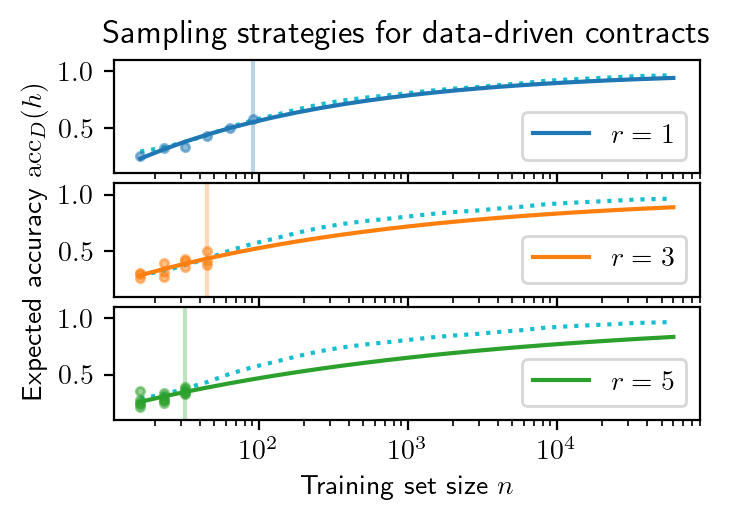

In [9]:
fig,axs = plt.subplots(3,1,figsize=(3.7,2.7), tight_layout={'w_pad':1,'h_pad':0})

plot_sampling_strategies(axs)
axs[0].set_title('Sampling strategies for data-driven contracts')
axs[1].set_ylabel('Expected accuracy $\\mathrm{acc}_D(h)$')
dclf.download_fig(fig,'sampling_strategies.pdf')

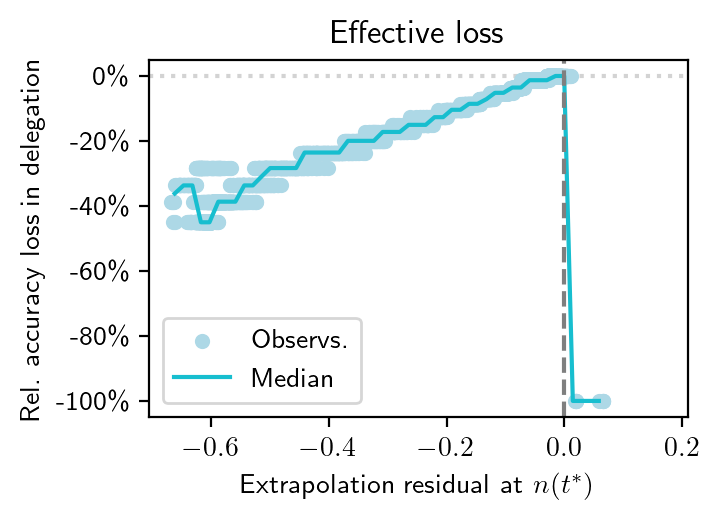

In [10]:
fig,ax = plt.subplots(figsize=(3.7,2.7), tight_layout={'w_pad':1,'h_pad':0})

plot_effective_loss(ax)
dclf.download_fig(fig,'effective_loss.pdf')